In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import spectral_embedding
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel, cosine_similarity
from sklearn.neighbors import kneighbors_graph

from scipy.sparse import csgraph

In [31]:
def plot_data(X_s, X_e, labels_s, labels_e):
    fig, axs = plt.subplots(1, 2)
    axs[0].scatter(X_s[:,0], X_s[:, 1], c=labels_s, alpha = 0.6, s=10)
    axs[1].scatter(X_e[:,0], X_e[:, 1], c=labels_e, alpha = 0.6, s=10)

In [32]:
square_df = pd.read_csv("data/square.txt", sep=' ')
X_square = square_df.values

ell_df = pd.read_csv("data/elliptical.txt", sep=' ')
X_ell = ell_df.values

In [33]:
scaler_ell = StandardScaler().fit(X_ell)
X_ell = scaler_ell.transform(X_ell)

In [34]:
kmeans_square = KMeans(n_clusters=2, n_init="auto").fit(X_square)
kmeans_ell = KMeans(n_clusters=2, n_init="auto").fit(X_ell)

In [35]:
spectral_square = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_square)
spectral_ell = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0, gamma=6).fit(X_ell)

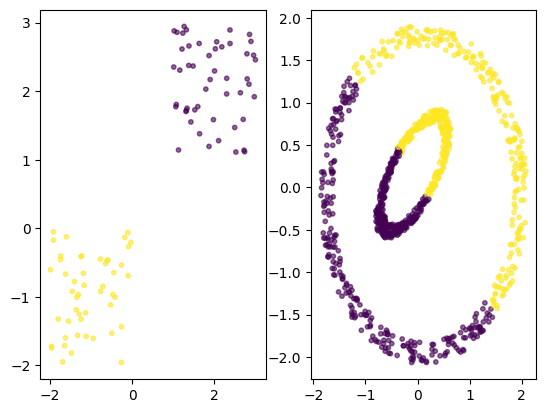

In [36]:
plot_data(X_square, X_ell, kmeans_square.labels_, kmeans_ell.labels_)

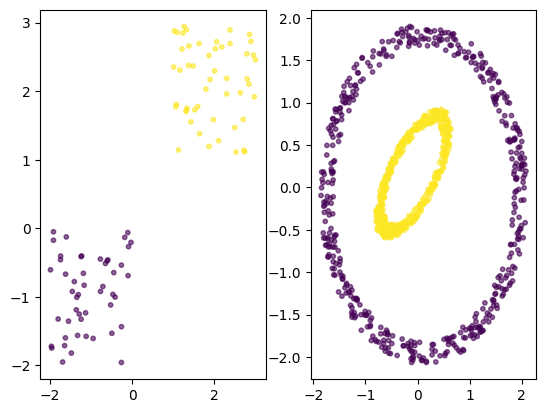

In [37]:
plot_data(X_square, X_ell, spectral_square.labels_, spectral_ell.labels_)

# ANALYSIS

## Cosine Similarity

In [14]:
def spectral_cos(X):
    sims = cosine_similarity(X)
    sims += abs(sims.min())
    spectral = SpectralClustering(n_clusters=2,affinity='precomputed', random_state=0).fit(sims)
    return spectral.labels_

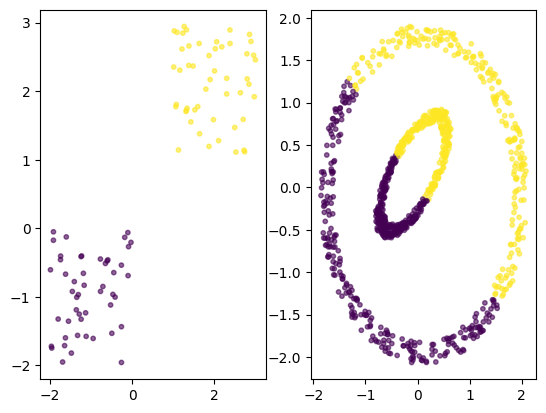

In [15]:
plot_data(X_square, X_ell, spectral_cos(X_square), spectral_cos(X_ell))

## Gaussian Kernel Similarity

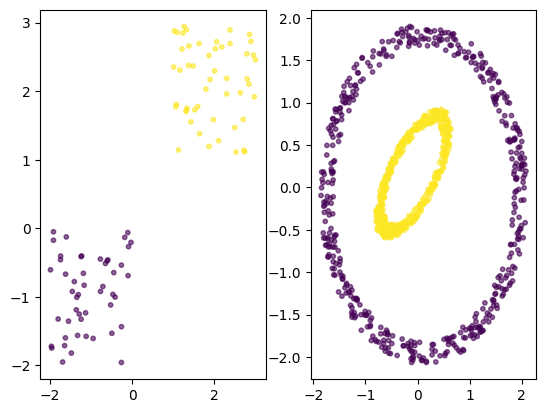

In [39]:
# Note that spectral clustering uses RBF by default which uses gaussian kernel similarity
plot_data(X_square, X_ell, spectral_square.labels_, spectral_ell.labels_)

## Laplacian

In [16]:
def spectral_lap(X, normalized):
    sim_matrix = rbf_kernel(X, gamma=7)
    eigen_vectors = spectral_embedding(sim_matrix, n_components=2, norm_laplacian=normalized)
    labels = KMeans(n_clusters=2, random_state=0, n_init=10).fit(eigen_vectors).labels_
    return labels

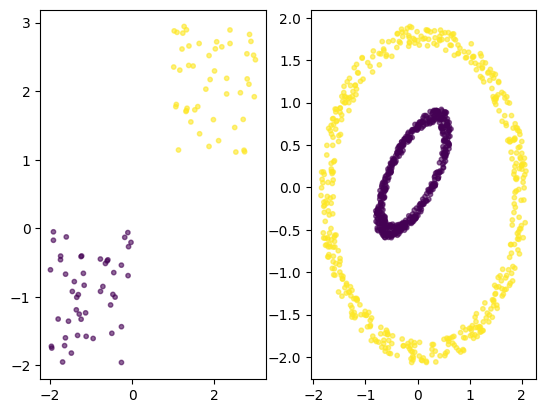

In [17]:
plot_data(X_square, X_ell, spectral_lap(X_square, normalized=False), spectral_lap(X_ell, normalized=False))

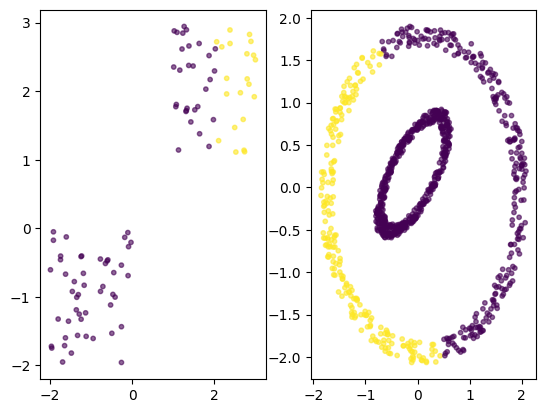

In [18]:
plot_data(X_square, X_ell, spectral_lap(X_square, normalized=True), spectral_lap(X_ell, normalized=True))

# Real-world

In [97]:
# get accurate numbering of clusters. 
# the generated cluster ids may not match the ones in the file, but they may still be clustered properly
def match_labels(y_pred, y_act):
    k_labels_matched = np.empty_like(y_pred)
    unique_y_pred = np.unique(y_pred)
    unique_y_act = np.unique(y_act)
    for k in unique_y_pred:
        match_nums = [(y_pred == k) & (y_act == t) for t in unique_y_act]
        k_labels_matched[y_pred == k] = unique_y_act[np.argmax(np.sum(match_nums, axis=1))]
    return k_labels_matched

# calculate accuracy and sse for kmeans
def kmeans_metrics(X, y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(X)
    acc = np.sum(match_labels(kmeans.labels_, y) == y) / len(y)
    sse = np.sum((y - match_labels(kmeans.labels_, y)) ** 2)
    return acc, sse

# calculate accuracy and sse for spectral
def spectral_metrics(X, y, n_clusters):
    spectral = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0).fit(X)
    acc = np.sum(match_labels(spectral.labels_, y) == y) / len(y)
    sse = np.sum((y - match_labels(spectral.labels_, y)) ** 2)
    return acc, sse

In [40]:
cho = pd.read_csv("data/cho.txt", sep='\t', index_col=None, names=range(18))
iyer = pd.read_csv("data/iyer.txt", sep='\t', index_col=None, names=range(14))

#remove first (index) col
cho = cho.iloc[:, 1:]   
iyer = iyer.iloc[:, 1:] 

# the first col represents cluster ids. counting the unique cluster ids gives the number of clusters
n_clusters_cho = len(cho.iloc[:, 0].unique())
n_clusters_iyer = len(iyer.iloc[:, 0].unique()) - 1 # -1 because iyer has outliers (-1 cluster ID)

In [41]:
cho_arr = cho.values
iyer_arr = iyer.values

# data and truth vals
cho_X, cho_y = cho_arr[:, 1:], cho_arr[:, 0]
iyer_X, iyer_y = iyer_arr[:, 1:], iyer_arr[:, 0]

In [42]:
# remove noise by omiting rows where cluster id is -1
iyer_X_no_noise = iyer_X[iyer_y != -1]
iyer_y_no_noise = iyer_y[iyer_y != -1]

# process iyer data
# with noise
scaler = StandardScaler().fit(iyer_X)
iyer_X_processed = scaler.transform(iyer_X)
# without noise
scaler = StandardScaler().fit(iyer_X_no_noise)
iyer_X_no_noise_processed = scaler.transform(iyer_X_no_noise)

# process cho data
scaler = StandardScaler().fit(cho_X)
cho_X_processed = scaler.transform(cho_X)

# Kmeans

In [103]:
# normalization for cho
# cho non normalized
print(kmeans_metrics(cho_X, cho_y, n_clusters_cho))

# cho normalized
print(kmeans_metrics(cho_X_processed, cho_y, n_clusters_cho))

(0.655440414507772, 462.0)
(0.6528497409326425, 353.0)


In [109]:
# normalization for iyer
# iyer non normalized
print(kmeans_metrics(iyer_X_no_noise, iyer_y_no_noise, n_clusters_iyer))

# iyer normalized
print(kmeans_metrics(iyer_X_no_noise_processed, iyer_y_no_noise, n_clusters_iyer))

(0.5475206611570248, 1277.0)
(0.5020661157024794, 1420.0)


In [114]:
# iyer with and without noise
# iyer with noise
print(kmeans_metrics(iyer_X_processed, iyer_y, n_clusters_iyer))

# iyer without noise
print(kmeans_metrics(iyer_X_no_noise_processed, iyer_y_no_noise, n_clusters_iyer))

(0.47195357833655704, 2366.0)
(0.5020661157024794, 1420.0)


# Spectral

In [95]:
# normalization for cho
# cho non normalized
print(spectral_metrics(cho_X, cho_y, n_clusters_cho))

# cho normalized
print(spectral_metrics(cho_X_processed, cho_y, n_clusters_cho))

(0.6528497409326425, 495.0)
(0.6476683937823834, 461.0)


In [27]:
# normalization for iyer
# iyer non normalized
print(spectral_metrics(iyer_X_no_noise, iyer_y_no_noise, n_clusters_iyer))

# iyer normalized
print(spectral_metrics(iyer_X_no_noise_processed, iyer_y_no_noise, n_clusters_iyer))

(0.4834710743801653, 1052.0)
(0.49586776859504134, 1510.0)


/usr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [113]:
# iyer with and without noise
# iyer with noise
print(spectral_metrics(iyer_X_processed, iyer_y, n_clusters_iyer))

# iyer without noise
print(spectral_metrics(iyer_X_no_noise_processed, iyer_y_no_noise, n_clusters_iyer))

(0.4564796905222437, 2471.0)
(0.49586776859504134, 1510.0)
